# Import and misc

In [36]:
%pip install torchaudio==0.9.1

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 2.3 MB/s 
     |████████████████████████████████| 831.4 MB 2.0 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.7.0 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.4.0 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
enot-utils 1.0.2 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [85]:
%pip install thop

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [109]:
%pip install wandb

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.7 MB 2.4 MB/s 
     |████████████████████████████████| 140 kB 56.1 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6488 sha256=6d2f4956c05de0ae322e774ea6187e4878145cad36f3080c5f0d006c2dc477b2
  Stored in directory: /tmp/xdg_cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8784 sha256=67890fc8b3a6b176908909a1faa575a6e9c62bd8cf1de1a02999b0783700eea2
  Stored in directory: /tmp/xdg_cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/bin/pytho

In [111]:
import wandb
wandb.login()

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  fe8504d80381f16d7e7ff1d4f340272dcddc77b4


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [37]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [220]:

@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [40]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-19 15:58:02--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.165.128, 2a00:1450:4010:c0d::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.165.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  77.7MB/s    in 26s     

2021-11-19 15:58:28 (55.2 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [42]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [43]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [44]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [47]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/cat/f4386675_nohash_0.wav,cat,0
1003,speech_commands/eight/763188c4_nohash_3.wav,eight,0
38126,speech_commands/down/c2d15ea5_nohash_0.wav,down,0
144,speech_commands/eight/c948d727_nohash_2.wav,eight,0
31651,speech_commands/three/1678e6f1_nohash_1.wav,three,0


In [48]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/cat/f4386675_nohash_0.wav,cat,0
1003,speech_commands/eight/763188c4_nohash_3.wav,eight,0
38126,speech_commands/down/c2d15ea5_nohash_0.wav,down,0
144,speech_commands/eight/c948d727_nohash_2.wav,eight,0
31651,speech_commands/three/1678e6f1_nohash_1.wav,three,0


### Augmentations

In [49]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [50]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [51]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [52]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [53]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [54]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [55]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          #num_workers=2, 
                          pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        #num_workers=2, 
                        pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [218]:

class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [222]:
del_datasphere_variables('melspec_val')

In [223]:

melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [58]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [59]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [60]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [61]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [62]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [63]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [75]:

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
    
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)
print(config)
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)
TaskConfig(keyword='sheila', batch_size=128, learning_rate=0.0003, weight_decay=1e-05, num_epochs=20, n_mels=40, cnn_out_channels=8, kernel_size=(5, 20), stride=(2, 8), hidden_size=64, gru_num_layers=2, bidirectional=False, num_classes=2, sample_rate=16000, device=device(type='cuda', index=0))


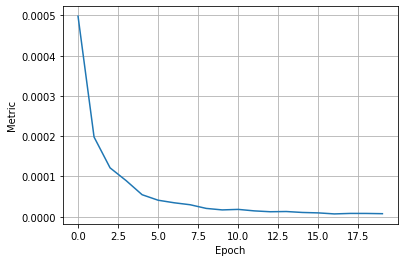

END OF EPOCH 19


In [80]:

# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [83]:

torch.save(model.state_dict(), 'base_model.pt')

In [174]:

len([0.000497902332430891,
              0.00019790774798032084,
              0.00012132620987178575,
              8.969820769184061e-05,
              5.461499546242601e-05,
              4.0961246596819505e-05,
              3.462371106566824e-05,
              2.971838695398618e-05,
              2.064174708310004e-05,
              1.6912029844898962e-05,
              1.818311747967789e-05,
              1.4489205526963542e-05,
              1.2352823492921966e-05,
              1.2913772965547409e-05,
              1.056255921858545e-05,
              9.500335749145783e-06,
              6.952192932006807e-06,
              8.17554018613676e-06,
              8.109897162744421e-06,
              7.513142404632249e-06])

20

In [81]:
history

defaultdict(list,
            {'val_metric': [0.000497902332430891,
              0.00019790774798032084,
              0.00012132620987178575,
              8.969820769184061e-05,
              5.461499546242601e-05,
              4.0961246596819505e-05,
              3.462371106566824e-05,
              2.971838695398618e-05,
              2.064174708310004e-05,
              1.6912029844898962e-05,
              1.818311747967789e-05,
              1.4489205526963542e-05,
              1.2352823492921966e-05,
              1.2913772965547409e-05,
              1.056255921858545e-05,
              9.500335749145783e-06,
              6.952192932006807e-06,
              8.17554018613676e-06,
              8.109897162744421e-06,
              7.513142404632249e-06]})

## Стриминг

In [311]:
#Нужен новый класс внимания, который бы хранил что-то с предыдущих шагов
class AttentionForStreaming(Attention):
    def __init__(self, hidden_size):
        super().__init__(hidden_size)
    
    #Мне не нравится использовать слово input - это ключевое слово в python
    #У нас могло остаться что-то с предыдущих шагов
    def forward(self, data, saved=None):
        #Считаем энергию для входа (считаю, что в входе только ноые данные)
        energy = self.energy(data)
        if saved is not None:
            energy = torch.cat((saved, energy), dim=-2)
        #Далее то же самое, что и было
        alpha = torch.softmax(energy, dim=-2)
        #но не забудем вернуть новую энергию
        return (data * alpha).sum(dim=-2), energy


#Если мы  поменяли вид внимания, нам надо создать другую crnn
#Вид gru точно такой же, форвард менять не буду
#Самый капец будет в модели стриминга
class CRNNForStreaming(CRNN):
    def __init__(self, config):
        super().__init__(config)
        self.attention = AttentionForStreaming(config.hidden_size)
    #Форвард такой же, за исключением части с вниманием, так как мы возвращаем еще 
    #"энергию", хотя в форварде она не нужна 
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector, saved = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output
    #В стриминге нам (как минимум на первом шаге) нам понядобится куча всяких выходов, поэтому напишу спец форвард
    #Далее нам снова это понадобится, но у нас уже будет хиддены с предыдущих шагов, поэтому добавлю аргумент
    def forwardAllInfo(self, input, hidden=None, saved=None):
        #Тут убрала, так как в стриминге это уже сделала
        #input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        if hidden is None:
             gru_output, hidden_output = self.gru(conv_output)
        else:
             gru_output, hidden_output = self.gru(conv_output, hidden)
       
        if saved is None:
            contex_vector, saved_output = self.attention(gru_output)
        else:
            contex_vector, saved_output = self.attention(gru_output, saved)
        output = self.classifier(contex_vector)
        return conv_output, gru_output, hidden_output, contex_vector, saved_output, output

    
#Хз, от чего ее можно унаследовать, пусть не от чего    
class Streaming():
    def __init__(self,  max_window_length=32, streaming_step_size=1):
        
        #Задание 1, пункт i
        self.max_window_length = max_window_length
        #Задание 2, пункт ii
        #TODO понять, что это за муть
        self.streaming_step_size = streaming_step_size
        

    def validate(self, model, data):
        #Это мы многоканалим запись, как обычно
        data = data.unsqueeze(1)
        model.eval()
        #Так как мы подаем по таймстемпу, а пересчитываем, только если влазит одна свертка, то нам нада
        #сохранить размер ядра и свертки !ПО ВРЕМЕНИ, НЕ ПО КАНАЛАМ!, так как за один шаг мы жрем все каналы
        kernel = model.conv[0].weight.shape[-1]
        stride = model.conv[0].stride[-1]
        #Первым шагом мы прогоняем max_window_length таймстемпов через модель, сохраняем 
        input = data[:,:,:, :self.max_window_length]
        conv_output, gru_output, hidden_output, contex_vector, saved_output, output = model.forwardAllInfo(input)
        #Это мы добавляем дим - время (то есть какой таймстемп обрабатываем)
        #Мне надо название для итогового вектора output (это слово для вывода модельки), добавлю артикль :)
        the_output = output.unsqueeze(1)
        #Теперь будем запихивать по одному таймстемпу
        for time in range(self.max_window_length, data.shape[-1]):
            #Пересчитывам если впихиваается одна свертка
            #То есть текущаее время - размер ядра делится на отступ без остатка, так ведь?
            #Вроде бы картинка в чате была такая
            if (time - kernel) % stride == 0:
                #Забываем предыдущий аутпут гру и что-то сохраненное в аттеншне
                gru_output, saved_output = gru_output[:,1:], saved_output[:,1:]
                
                input = data[:,:,:, time - kernel + 1:time + 1]
                
                #Теперь запизиваем все в модель, не забывая, что у нас есть сохраненные состояния
                conv_output, gru_output, hidden_output, contex_vector, saved_output, output = model.forwardAllInfo(input, hidden=hidden_output, saved=saved_output)
                output = output.unsqueeze(1)
                the_output = torch.cat((the_output, output[:, -1:]), dim=1)
                 
            #А если не впихивается??
            else:
                #Скорее всего копируем предыдущий output
                the_output = torch.cat((the_output, the_output[:, -1:]), dim=1)
        return the_output
                
                
        

In [312]:
mm = CRNNForStreaming(TaskConfig())

Так как у нас все то же самое, что и у обычной модели, можно загрузить базу

In [313]:
mm.load_state_dict(torch.load('base_model.pt', map_location='cpu'))
mm.eval()

CRNNForStreaming(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): AttentionForStreaming(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

Немного потетсим. Сначала выберем аудио, которое будем к

In [330]:
for t in train_set:
    print(t)
    print(t['wav'].shape)
    if t['label'] == 1:
        break

{'wav': tensor([-0.0083, -0.0118, -0.0174,  ...,  0.0059, -0.0012, -0.0044]), 'keywors': 'on', 'label': 0}
torch.Size([16000])
{'wav': tensor([-0.0042,  0.0047,  0.0083,  ...,  0.0074,  0.0140,  0.0305]), 'keywors': 'seven', 'label': 0}
torch.Size([16000])
{'wav': tensor([-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0003, -0.0003]), 'keywors': 'two', 'label': 0}
torch.Size([16000])
{'wav': tensor([-0.0702,  0.0529,  0.0216,  ...,  0.0755,  0.0259,  0.0884]), 'keywors': 'two', 'label': 0}
torch.Size([16000])
{'wav': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]), 'keywors': 'sheila', 'label': 1}
torch.Size([16000])


Потестим, если сначала склеить, потом взять mel

In [361]:
test_audio = torch.cat([train_set[0]['wav'], 
                        train_set[1]['wav'], 
                        train_set[4]['wav'], #Есть ключевое слово
                        train_set[2]['wav'], 
                        train_set[3]['wav']])

In [362]:
max_window_length = 40
st = Streaming(max_window_length = max_window_length)
test_output = st.validate(mm, melspec_train(test_audio.unsqueeze(0).to(config.device))) 
check = F.softmax(test_output, dim=-1)[0].detach().numpy()

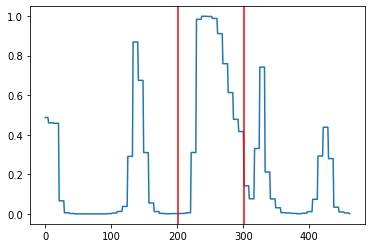

In [364]:
plt.plot(list(range(check.shape[0])), check[:,1])
plt.axvline(x=201, color='red')
plt.axvline(x=301, color='red')

In [367]:
test_mel = torch.cat([melspec_train(train_set[0]['wav']), 
                      melspec_train(train_set[1]['wav']), 
                      melspec_train(train_set[4]['wav']), #Есть ключевое слово
                      melspec_train(train_set[2]['wav']), 
                      melspec_train(train_set[3]['wav'])], dim=-1)

In [369]:
max_window_length = 40
st = Streaming(max_window_length = max_window_length)
test_output = st.validate(mm, test_mel.unsqueeze(0).to(config.device)) 
check = F.softmax(test_output, dim=-1)[0].detach().numpy()

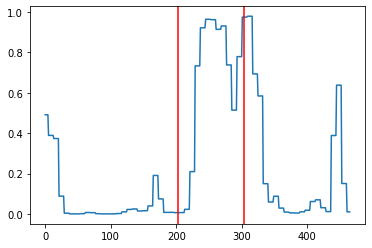

In [370]:
plt.plot(list(range(check.shape[0])), check[:,1])
plt.axvline(x=202, color='red')
plt.axvline(x=303, color='red')